# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

from trainer import Trainer

DATA_FOLDER = "."

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Training set creation
__Question 1 (2 points):__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [4]:
class SubDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = list(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __repr__(self):
        upper_repr = repr(self.dataset)
        upper_repr = "\n    ".join(upper_repr.split("\n"))
        return f"SubDataset of length {len(self)} from\n    {upper_repr}"


X_train = datasets.CIFAR10(root=DATA_FOLDER, train=True, download=True)

X = SubDataset(X_train, range(100, len(X_train)))
X_train = SubDataset(X_train, range(100))
print(X_train, X, sep="\n")

Extracting /home/raph/data/pytorch/cifar-10-python.tar.gz to /home/raph/data/pytorch/
SubDataset of length 100 from
    Dataset CIFAR10
        Number of datapoints: 50000
        Root location: /home/raph/data/pytorch/
        Split: Train
SubDataset of length 49900 from
    Dataset CIFAR10
        Number of datapoints: 50000
        Root location: /home/raph/data/pytorch/
        Split: Train


In [5]:
# Check the number of images (group by classes)

from functools import reduce

def f(d, elt):
    c = d.get(elt, 0)
    d[elt] = c + 1
    return d

d = reduce(f, map(lambda x: x[1], list(X_train)), {})
sorted(d.items())

[(0, 6),
 (1, 16),
 (2, 13),
 (3, 13),
 (4, 11),
 (5, 7),
 (6, 7),
 (7, 11),
 (8, 4),
 (9, 12)]

In [6]:
## Compute mean / std for our dataset (only on the training set)

cifar_train = datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=transforms.ToTensor())

mean = torch.zeros(3)
std = torch.zeros(3)
for img, _ in cifar_train:
    mean += img.mean(dim=[1, 2])
    std += img.std(dim=[1, 2])
mean /= len(cifar_train)
std /= len(cifar_train)


# For finetuning use the value used for the training of the pretrained models
mean_finetune = [0.485, 0.456, 0.406]
std_finetune = [0.229, 0.224, 0.225]

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

When there is not a lot of annotated data, it's difficult to evaluate our methods as we should not used the same data both for training and testing. It's even harder to create a validation set in order to know when to stop the training or which hyperparameters to use.

Here the test set is given and large but should only be used to evaluate the final result of each methods. And it shouldn't be used as a validation set. (note that in order to have the best model, we should totally merge the train and the test and split again in a new train / validation / test, but that's not the point here)

We could create a small validation set from the training data, but then we would have less data to train on and the results will have a lot of variability. We could also try to do crossvalidation to find the best epoch for early stopping but this would require to do multiple trainings and we would like to avoid it.

We have thus choosen the very imperfect method to use a small part of the test set as a validation set.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points):__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [7]:
## MODEL ##
# Code from pytorch-cifar github (https://github.com/kuangliu/pytorch-cifar)
# Renamed the last linear layer in fc in order to match the name of torchvision resnets

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [8]:
# Loss / errors
criterion = nn.CrossEntropyLoss()

def errors(predictions, targets):
    predictions = predictions.argmax(dim=1)
    return 1 - (predictions == targets).sum() / len(targets)

In [8]:
# No data augmentation

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=train_transform, download=True)
X_train = SubDataset(X_train, range(100))
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=test_transform, download=True)
X_val = SubDataset(X_test, range(200))
X_test = SubDataset(X_test, range(200, len(X_test)))

train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val, 128, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test, 128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model = ResNet18()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optimizer, save_dir="experiments", save_mode="best")

In [ ]:
# Train and select best

trainer.train(10, train_loader, criterion, device, val_loader=val_loader, val_criterion=errors)
model.load_state_dict(torch.load(f"experiments/{trainer.best_epoch}.pt"))

# Accuracy
train_accuracy = 1 - trainer.validate(train_loader, errors, device)
test_accuracy = 1 - trainer.validate(test_loader, errors, device)

print("Accuracy on train:", train_accuracy)
print("Accuracy on test:", test_accuracy)

Batch 10/10 --- Training loss 2.5442
Batch 2/2 --- Validation loss 0.8550
Epoch [0/10] --- Averaged training loss: 3.0935, Averaged validation loss: 0.8550
Batch 10/10 --- Training loss 2.9699
Batch 2/2 --- Validation loss 0.8550
Epoch [1/10] --- Averaged training loss: 2.1058, Averaged validation loss: 0.8550
Batch 10/10 --- Training loss 1.5489
Batch 2/2 --- Validation loss 0.8850
Epoch [2/10] --- Averaged training loss: 1.7575, Averaged validation loss: 0.8850
Batch 10/10 --- Training loss 1.7705
Batch 2/2 --- Validation loss 0.7750
Epoch [3/10] --- Averaged training loss: 1.5020, Averaged validation loss: 0.7750
Batch 10/10 --- Training loss 1.1591
Batch 2/2 --- Validation loss 0.8000
Epoch [4/10] --- Averaged training loss: 1.3059, Averaged validation loss: 0.8000
Batch 10/10 --- Training loss 1.5705
Batch 2/2 --- Validation loss 0.7850
Epoch [5/10] --- Averaged training loss: 1.0318, Averaged validation loss: 0.7850
Batch 10/10 --- Training loss 1.4330
Batch 2/2 --- Validation lo

In [ ]:
base_losses = trainer.losses
base_accuracy = test_accuracy

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_finetune, std_finetune),
    transforms.Resize(224),  # Important to resize in order to be able to use pretrained convolutions
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=transform, download=True)
X_train = SubDataset(X_train, range(100))
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=transform, download=True)
X_val = SubDataset(X_test, range(200))
X_test = SubDataset(X_test, range(200, len(X_test)))

train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val, 128, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test, 128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class FinetunedResnet(nn.Module):
    def __init__(self, resnet, n_classes):
        super().__init__()
        self.resnet = resnet
        self.resnet.fc = nn.Linear(512, n_classes)

    def forward(self, x):
        return self.resnet(x)

    def train(self, mode=True):
        # Keep eval mode for batch normalization even when retraining. (We only train the last fc here)
        super().train(False)

In [ ]:
model = FinetunedResnet(torchvision.models.resnet18(pretrained=True), 10)
optimizer = torch.optim.Adam(model.resnet.fc.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, save_dir="experiments", save_mode="best")

In [ ]:
# Train only fc and select best

trainer.train(10, train_loader, criterion, device, val_loader=val_loader, val_criterion=errors)
model.load_state_dict(torch.load(f"experiments/{trainer.best_epoch}.pt"))

# Accuracy
train_accuracy = 1 - trainer.validate(train_loader, errors, device)
test_accuracy = 1 - trainer.validate(test_loader, errors, device)

print("Accuracy on train:", train_accuracy)
print("Accuracy on test:", test_accuracy)

Batch 10/10 --- Training loss 2.3854
Batch 2/2 --- Validation loss 0.7600
Epoch [0/10] --- Averaged training loss: 3.7544, Averaged validation loss: 0.7600
Batch 10/10 --- Training loss 0.5476
Batch 2/2 --- Validation loss 0.5700
Epoch [1/10] --- Averaged training loss: 1.9511, Averaged validation loss: 0.5700
Batch 10/10 --- Training loss 0.1028
Batch 2/2 --- Validation loss 0.5850
Epoch [2/10] --- Averaged training loss: 0.3973, Averaged validation loss: 0.5850
Batch 10/10 --- Training loss 0.0615
Batch 2/2 --- Validation loss 0.4500
Epoch [3/10] --- Averaged training loss: 0.2676, Averaged validation loss: 0.4500
Batch 10/10 --- Training loss 0.0695
Batch 2/2 --- Validation loss 0.3900
Epoch [4/10] --- Averaged training loss: 0.1043, Averaged validation loss: 0.3900
Batch 10/10 --- Training loss 0.0138
Batch 2/2 --- Validation loss 0.3750
Epoch [5/10] --- Averaged training loss: 0.0443, Averaged validation loss: 0.3750
Batch 10/10 --- Training loss 0.0243
Batch 2/2 --- Validation lo

In [ ]:
finetune_losses = trainer.losses
finetune_accuracy = test_accuracy

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points):__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

The main problem with these images is that they are 32x32 images. Translation are limited if we want to keep the information of the image intact. Moreover with scaling and rotation, we have to interpolate the image, and with such a low resolution it's not really good. But with reasonnable parameters, the images are quite preserved, and these transformations can still be used for data augmentation.

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [ ]:
fill_color = tuple(map(lambda x: int(255*x), mean))

augmented_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.RandomRotation(10, fill=fill_color)], 0.3),
    transforms.RandomApply([transforms.GaussianBlur(35, 0.5)], 0.3),
#     transforms.RandomCrop(32, 3, padding_mode="reflect"),
#     transforms.RandomPerspective,
    transforms.RandomApply([transforms.RandomResizedCrop(32, scale=(0.6, 1.0))], 0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomApply([transforms.RandomErasing(1, scale=(0.01, 0.1))], 0.3),
])

base_transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=augmented_transform)
X_train = SubDataset(X_train, range(100))
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=base_transform)
X_val = SubDataset(X_test, range(200))
X_test = SubDataset(X_test, range(200, len(X_test)))

train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val, 128, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test, 128, shuffle=False)

In [ ]:
X = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=base_transform)

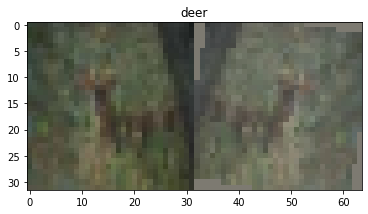

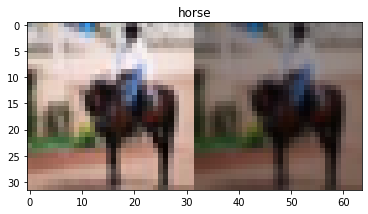

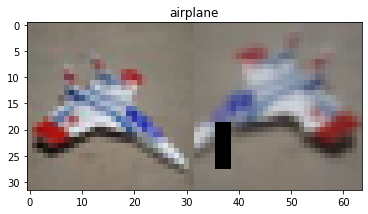

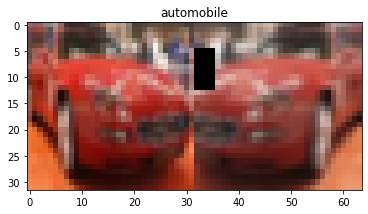

In [ ]:
# Can be used to visualized transforms. Done without the normalization transform to improve visualization

def check_transforms(i, X, X_aug):
    "Plot the original image and its randomly augmented version"
    img_base, label = X[i]
    img_aug = X_aug[i][0]
    plt.title(cifar_train.classes[label])
    plt.imshow(torch.cat((img_base, img_aug), dim=2).permute(1, 2, 0))
    plt.show()

check_transforms(10, X, X_train)
check_transforms(11, X, X_train)
check_transforms(30, X, X_train)
check_transforms(5, X, X_train)

In [ ]:
model = ResNet18()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
trainer = Trainer(model, optimizer, save_dir="experiments", save_mode="best")

In [ ]:
# Train and select best. Has to train on more epochs

trainer.train(60, train_loader, criterion, device, val_loader=val_loader, val_criterion=errors)
model.load_state_dict(torch.load(f"experiments/{trainer.best_epoch}.pt"))

# Accuracy
train_accuracy = 1 - trainer.validate(train_loader, errors, device)
test_accuracy = 1 - trainer.validate(test_loader, errors, device)

print("Accuracy on train:", train_accuracy)
print("Accuracy on test:", test_accuracy)

Batch 10/10 --- Training loss 2.6000
Batch 2/2 --- Validation loss 0.9200
Epoch [0/60] --- Averaged training loss: 2.7385, Averaged validation loss: 0.9200
Batch 10/10 --- Training loss 2.2999
Batch 2/2 --- Validation loss 0.9250
Epoch [1/60] --- Averaged training loss: 2.3416, Averaged validation loss: 0.9250
Batch 10/10 --- Training loss 2.2437
Batch 2/2 --- Validation loss 0.8050
Epoch [2/60] --- Averaged training loss: 2.0595, Averaged validation loss: 0.8050
Batch 10/10 --- Training loss 2.2002
Batch 2/2 --- Validation loss 0.8750
Epoch [3/60] --- Averaged training loss: 2.0206, Averaged validation loss: 0.8750
Batch 10/10 --- Training loss 2.1203
Batch 2/2 --- Validation loss 0.8350
Epoch [4/60] --- Averaged training loss: 1.9295, Averaged validation loss: 0.8350
Batch 10/10 --- Training loss 1.7070
Batch 2/2 --- Validation loss 0.8000
Epoch [5/60] --- Averaged training loss: 1.8429, Averaged validation loss: 0.8000
Batch 10/10 --- Training loss 1.2717
Batch 2/2 --- Validation lo

In [ ]:
augmented_losses = trainer.losses
augmented_accuracy = test_accuracy

# Conclusions

__Question 7 (5 points):__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In order to compare the different methods, we have use the same model through the experiments: a ResNet18. (We used only the torchvision's implementation for the finetuning experiments)

The first method consists in using only the given 100 data with no pretrained features or data augmentation. With Adam optimizer and a basic learning rate, the model is able to reach from 18 to 23 percent of accuracy on the test set. It's not a lot and but this method is the simplest one.

The second method consists in using a pretrained model on ImageNet. We have retrained a linear layer above the convolutionnal model. (We also tried to finetune the whole model, and with different learning rates, but it did not yields better results.). We achieved to reach from 64 to 68 percent of accuracy on the test set with this method. This is the best accuracy we got and it's quite simple to do, but it requires to have access to a pretrained model and adapt the dataset to it. For instance as the pretrained model has been trained on 224x224 images, we had to resize our images to this size (And we therefore need more computationnal power.)

The third method consists in using data augmentation. Previous method were designed without any data augmentation. Here the idea is to augment our dataset with some modified images. We decided to randomly augment the dataset online. The idea is to learn to be more robust. The training is a bit harder with it, we use a smaller learning rate and more epochs. But at the end we are able to reach from 25 to 28 percent of accuracy. (which is a bit better than without it.). Nonetheless it's quite hard to know which transformations to use to augment our dataset and with which intensity. (Even more with small images)

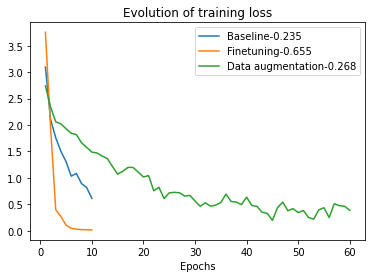

In [ ]:
plt.title("Evolution of training loss")
plt.plot(range(1, 11), base_losses[0], label=f"Baseline-{base_accuracy:.3f}")
plt.plot(range(1, 11), finetune_losses[0], label=f"Finetuning-{finetune_accuracy:.3f}")
plt.plot(range(1, 61), augmented_losses[0], label=f"Data augmentation-{augmented_accuracy:.3f}")
plt.xlabel("Epochs")
plt.legend()
plt.show()

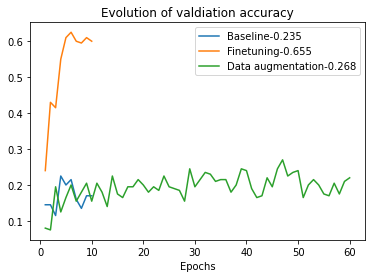

In [ ]:
plt.title("Evolution of valdiation accuracy")
plt.plot(range(1, 11), 1-base_losses[1], label=f"Baseline-{base_accuracy:.3f}")
plt.plot(range(1, 11), 1-finetune_losses[1], label=f"Finetuning-{finetune_accuracy:.3f}")
plt.plot(range(1, 61), 1-augmented_losses[1], label=f"Data augmentation-{augmented_accuracy:.3f}")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In the following section we will present two more experiments. We can sum up very quickly and roughly the results with:
<ul>
<li>Supervised without augmentation: around 20%</li>
<li>Supervised with augmentation: around 26%</li>
<li>Self supervision with rotation prediction: Around 35%</li>
<li>Pretrained model on ImageNet: Around 65%</li>
<li>FixMatch: Greater than 75%</li>
</ul>

(FixMatch results were by most the hardest to have, and require a lot of computations)

# Weak supervision

__Bonus \[open\] question (up to 3 points):__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

We decided to use self supervision on the unlabelled dataset. On this dataset we will apply some random rotation (between 0, 90, 180 and 270 degree). Then we train a network to predict which rotation has been used on the image. Hopefully the network will learn some useful feature to use in our real task with our tiny dataset, and we will be able to finetune the network for our task

In [ ]:
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        k = torch.randint(0, 4, (1,)).item()
        image = torch.rot90(image, k, [1, 2])
        return image, k

    def __len__(self):
        return len(self.dataset)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

X_train = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, transform=transform, download=True)
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, transform=transform, download=True)

# Rotation Datasets
X_train_rot = RotationDataset(X_train)
X_test_rot = RotationDataset(X_test)
train_loader_rot = torch.utils.data.DataLoader(X_train_rot, 64, shuffle=True)
test_loader_rot = torch.utils.data.DataLoader(X_test_rot, 128, shuffle=False)

# Finetune Datasets
X_train = SubDataset(X_train, range(100))
X_val = SubDataset(X_test, range(200))
X_test = SubDataset(X_test, range(200, len(X_test)))

train_loader = torch.utils.data.DataLoader(X_train, 10, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val, 128, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test, 128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = ResNet18()
model.linear = nn.Linear(512, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optimizer, save_dir="experiments", save_mode="best")

In [ ]:
# Pretrained and take the model that performs the best over X_test
# Train and select best. Has to train on more epochs

trainer.train(20, train_loader_rot, criterion, device, val_loader=test_loader_rot, val_criterion=errors)
model.load_state_dict(torch.load(f"experiments/{trainer.best_epoch}.pt"))

Batch 782/782 --- Training loss 0.8596
Batch 79/79 --- Validation loss 0.4128
Epoch [0/20] --- Averaged training loss: 1.0895, Averaged validation loss: 0.4128
Batch 782/782 --- Training loss 1.1835
Batch 79/79 --- Validation loss 0.3715
Epoch [1/20] --- Averaged training loss: 0.9504, Averaged validation loss: 0.3715
Batch 782/782 --- Training loss 0.6408
Batch 79/79 --- Validation loss 0.3423
Epoch [2/20] --- Averaged training loss: 0.8715, Averaged validation loss: 0.3423
Batch 782/782 --- Training loss 0.6107
Batch 79/79 --- Validation loss 0.3113
Epoch [3/20] --- Averaged training loss: 0.7970, Averaged validation loss: 0.3113
Batch 782/782 --- Training loss 0.6417
Batch 79/79 --- Validation loss 0.2909
Epoch [4/20] --- Averaged training loss: 0.7337, Averaged validation loss: 0.2909
Batch 782/782 --- Training loss 0.9990
Batch 79/79 --- Validation loss 0.2654
Epoch [5/20] --- Averaged training loss: 0.6750, Averaged validation loss: 0.2654
Batch 782/782 --- Training loss 0.4763
B

<All keys matched successfully>

In [ ]:
trainer.best_epoch

17

In [ ]:
model = FinetunedResnet(model, 10)
optimizer = torch.optim.Adam(model.resnet.fc.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, save_dir="experiments", save_mode="best")

In [ ]:
# Train only fc and select best

trainer.train(20, train_loader, criterion, device, val_loader=val_loader, val_criterion=errors)
model.load_state_dict(torch.load(f"experiments/{trainer.best_epoch}.pt"))

# Accuracy
train_accuracy = 1 - trainer.validate(train_loader, errors, device)
accuracy = 1 - trainer.validate(test_loader, errors, device)

print("Accuracy on train:", train_accuracy)
print("Accuracy on test:", accuracy)

Batch 10/10 --- Training loss 2.6446
Batch 2/2 --- Validation loss 0.8450
Epoch [0/20] --- Averaged training loss: 2.5593, Averaged validation loss: 0.8450
Batch 10/10 --- Training loss 1.6780
Batch 2/2 --- Validation loss 0.6850
Epoch [1/20] --- Averaged training loss: 1.9071, Averaged validation loss: 0.6850
Batch 10/10 --- Training loss 1.0872
Batch 2/2 --- Validation loss 0.7150
Epoch [2/20] --- Averaged training loss: 1.5625, Averaged validation loss: 0.7150
Batch 10/10 --- Training loss 1.3430
Batch 2/2 --- Validation loss 0.7450
Epoch [3/20] --- Averaged training loss: 1.3397, Averaged validation loss: 0.7450
Batch 10/10 --- Training loss 0.9610
Batch 2/2 --- Validation loss 0.7450
Epoch [4/20] --- Averaged training loss: 1.2131, Averaged validation loss: 0.7450
Batch 10/10 --- Training loss 1.3593
Batch 2/2 --- Validation loss 0.7550
Epoch [5/20] --- Averaged training loss: 1.1164, Averaged validation loss: 0.7550
Batch 10/10 --- Training loss 0.5091
Batch 2/2 --- Validation lo

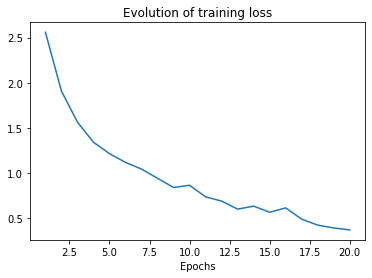

In [ ]:
plt.title("Evolution of training loss")
plt.plot(range(1, 21), trainer.losses[0])
plt.xlabel("Epochs")
plt.show()

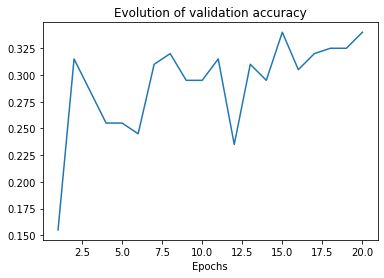

In [ ]:
plt.title("Evolution of validation accuracy")
plt.plot(range(1, 21), 1 - trainer.losses[1])
plt.xlabel("Epochs")
plt.show()

With this method we are able to reach around 36 percent of accuracy on the test set. We are able to use our unlabelled data to improve our results, but it requires more computationnal power. (We have train a model on the whole Cifar Dataset for 20 epochs here which is already a bit costly.)


We have also tried a more promising method: FixMatch. (https://arxiv.org/pdf/2001.07685.pdf) We first believed this method to be computationnally friendly but it's not the case. It works well, but many epochs are expected in order to have good results. We inspired from the pytorch implementation from https://github.com/kekmodel/FixMatch-pytorch.

Without waiting until the end of the training (and with the hyper parameters of the article) we are able to reach 78% of accuracy on the test set, which is our best result. Nonetheless this method is really time consuming, we could have maybe reduced the batch size to increase training speed, but we hadn't the time to really explore it.

In [9]:
# Code from https://github.com/kekmodel/FixMatch-pytorch: RandAugment

# code in this file is adpated from
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py
import logging
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

logger = logging.getLogger(__name__)

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


def my_augment_pool():
    # Test
    augs = [(AutoContrast, None, None),
            (Brightness, 1.8, 0.1),
            (Color, 1.8, 0.1),
            (Contrast, 1.8, 0.1),
            (Cutout, 0.2, 0),
            (Equalize, None, None),
            (Invert, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 1.8, 0.1),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (SolarizeAdd, 110, 0),
            (TranslateX, 0.45, 0),
            (TranslateY, 0.45, 0)]
    return augs


class RandAugmentPC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = my_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img

In [10]:
# Code from https://github.com/kekmodel/FixMatch-pytorch (WideResNet)

import logging

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)


def mish(x):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function (https://arxiv.org/abs/1908.08681)"""
    return x * torch.tanh(F.softplus(x))


class PSBatchNorm2d(nn.BatchNorm2d):
    """How Does BN Increase Collapsed Neural Network Filters? (https://arxiv.org/abs/2001.11216)"""

    def __init__(self, num_features, alpha=0.1, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True):
        super().__init__(num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, x):
        return super().forward(x) + self.alpha


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate, activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, channels[0], channels[1], block, 1, drop_rate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(
            n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(
            n, channels[2], channels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[3], num_classes)
        self.channels = channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    logger.info(f"Model: WideResNet {depth}x{widen_factor}")
    return WideResNet(depth=depth,
                      widen_factor=widen_factor,
                      drop_rate=dropout,
                      num_classes=num_classes)

In [11]:
class TransformUnlabelled(object):
    def __init__(self, mean, std):
        self.weak = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                  padding=int(32*0.125),
                                  padding_mode='reflect')])

        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                  padding=int(32*0.125),
                                  padding_mode='reflect'),
            RandAugmentMC(n=2, m=10)])
        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.normalize(weak), self.normalize(strong)

transform_unlabelled = TransformUnlabelled(mean, std)

transform_labelled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=32, padding=int(32*0.125), padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [12]:
X_train_l = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, download=True, transform=transform_labelled)
X_train_u = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=True, download=True, transform=transform_unlabelled)
X_test = torchvision.datasets.CIFAR10(root=DATA_FOLDER, train=False, download=True, transform=test_transform)

X_train_l = SubDataset(X_train_l, range(100))
X_train_u = SubDataset(X_train_u, range(100, len(X_train_u)))
X_val = SubDataset(X_test, range(200))
X_test = SubDataset(X_test, range(200, len(X_test)))

train_loader_l = torch.utils.data.DataLoader(X_train_l, 64, shuffle=True, drop_last=True)
train_loader_u = torch.utils.data.DataLoader(X_train_u, 64 * 7, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(X_val, 128, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test, 128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
def train_fix_match(n, model, loader_l, loader_u, optimizer, criterion, device):
    model.train()
    total_loss = 0
    N = 0
    iter_l = iter(loader_l)
    iter_u = iter(loader_u)
    for i in range(n):
        try:
            inputs_l, targets_l = next(iter_l)
        except StopIteration:
            iter_l = iter(loader_l)
            inputs_l, targets_l = next(iter_l)
        try:
            (inputs_weak, inputs_strong), _ = next(iter_u)
        except StopIteration:
            iter_u = iter(loader_u)
            (inputs_weak, inputs_strong), _ = next(iter_u)
        inputs = torch.cat((inputs_l, inputs_weak, inputs_strong)).to(device)
        targets_l = targets_l.to(device)

        batch_size = targets_l.shape[0]
        N += batch_size

        predictions = model(inputs)
        predictions_l = predictions[:batch_size]
        predictions_weak = predictions[batch_size:batch_size + inputs_weak.shape[0]]
        predictions_strong = predictions[-inputs_strong.shape[0]:]

        loss_l = criterion(predictions_l, targets_l).mean()

        predictions_weak = torch.softmax(predictions_weak.detach(), dim=1)
        max_probs, targets_u = torch.max(predictions_weak, dim=1)
        mask_u = (max_probs >= 0.95).float()

        loss_u = (criterion(predictions_strong, targets_u) * mask_u).mean()

        loss = loss_l + 1 * loss_u

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        total_loss += loss * batch_size

        print(f"\rBatch {i+1}/{n} --- Training loss {loss:.4f} ({loss_l.item():.3f} + {loss_u.item():.3f})", end="", flush=True)
    print(flush=True)
    return total_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    with torch.no_grad():
        loss = 0
        N = 0

        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            batch_size = inputs.shape[0]
            N += batch_size

            predictions = model(inputs)
            loss += criterion(predictions, targets).item() * batch_size

            print(f"\rBatch {i+1}/{len(dataloader)} --- Validation loss {loss / N:.4f}", end="", flush=True)
        print(flush=True)
    return loss / N

In [14]:
model = build_wideresnet(28, 2, 0, 10)
model.to(device)

no_decay = ['bias', 'bn']
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0005},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.SGD(grouped_parameters, lr=0.03, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss(reduction="none")

In [15]:
for i in range(50):  # Should save the best model and do more epochs (around 600 epochs)
    train_fix_match(500, model, train_loader_l, train_loader_u, optimizer, criterion, device)
    validate(model, val_loader, errors, device)

Batch 500/500 --- Training loss 0.2896 (0.010 + 0.279)
Batch 2/2 --- Validation loss 0.8600
Batch 500/500 --- Training loss 0.3394 (0.027 + 0.313)
Batch 2/2 --- Validation loss 0.8550
Batch 500/500 --- Training loss 0.2745 (0.005 + 0.269)
Batch 2/2 --- Validation loss 0.7950
Batch 500/500 --- Training loss 0.2713 (0.001 + 0.270)
Batch 2/2 --- Validation loss 0.8250
Batch 500/500 --- Training loss 0.2414 (0.004 + 0.237)
Batch 2/2 --- Validation loss 0.8000
Batch 500/500 --- Training loss 0.2670 (0.006 + 0.261)
Batch 2/2 --- Validation loss 0.8350
Batch 500/500 --- Training loss 0.2237 (0.003 + 0.221)
Batch 2/2 --- Validation loss 0.7800
Batch 500/500 --- Training loss 0.2691 (0.008 + 0.261)
Batch 2/2 --- Validation loss 0.7900
Batch 500/500 --- Training loss 0.2996 (0.002 + 0.298)
Batch 2/2 --- Validation loss 0.7850
Batch 500/500 --- Training loss 0.2086 (0.003 + 0.205)
Batch 2/2 --- Validation loss 0.7900
Batch 500/500 --- Training loss 0.2890 (0.010 + 0.279)
Batch 2/2 --- Validation 

In [20]:
print("Accuracy", 1 - validate(model, test_loader, errors, device))

Batch 77/77 --- Validation loss 0.2210
Accuracy 0.7789795920313621
